In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
conti_stocks_df = pd.read_csv(r"D:\streamlit_learn\streamlit_learn\conti.csv")
conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-04 00:00:00+02:00,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-07 00:00:00+02:00,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-08 00:00:00+02:00,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-09 00:00:00+02:00,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-10 00:00:00+02:00,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [3]:
# Convert with timezone awareness
conti_stocks_df['Date'] = pd.to_datetime(conti_stocks_df['Date'], utc=True)

# Remove timestamp:
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.tz_localize(None)

# Now you can floor to day
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.floor('D')

conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-03,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-06,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-07,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-08,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-09,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [4]:
conti_stocks_df_new = conti_stocks_df[['Close', 'Open', 'High', 'Low', 'Volume', 'Date']].copy()

In [5]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity of time series using ADF test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [6]:
for col in conti_stocks_df_new.columns:
    if col=='Date':
        break
    print('Stationarity test for', col)
    check_stationarity(conti_stocks_df_new[col])
    print("\n")

Stationarity test for Close
ADF Statistic: -1.4401384165922488
p-value: 0.5628892736540163
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Stationarity test for Open
ADF Statistic: -1.5128710515551775
p-value: 0.5271348775267674
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Stationarity test for High
ADF Statistic: -1.4437601859181097
p-value: 0.5611265920789154
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Stationarity test for Low
ADF Statistic: -1.5143843574967772
p-value: 0.5263839824826345
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Stationarity test for Volume
ADF Statistic: -4.492406724399752
p-value: 0.0002029464182511676
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567




In [7]:
# Difference
diffed = conti_stocks_df_new.copy()
diffed["Close"] = diffed["Close"].diff()
diffed["Open"] = diffed["Open"].diff()
diffed["High"] = diffed["High"].diff()
diffed["Low"] = diffed["Low"].diff()
diffed = diffed.dropna()
diffed.head()

,Close,Open,High,Low,Volume,Date
1,1.191017,-1.803505,-1.633352,0.952823,217077,2015-09-06
2,2.892456,0.374321,3.981359,1.973672,568550,2015-09-07
3,1.190994,6.159189,3.028539,3.198681,516951,2015-09-08
4,-0.578491,-4.117477,-2.347972,-1.395174,360871,2015-09-09
5,-0.884750,0.510421,-1.769497,-1.293098,357669,2015-09-10


In [9]:
train = train.apply(pd.to_numeric, errors='coerce')
test = test.apply(pd.to_numeric, errors='coerce')

In [10]:
train = train.dropna()
test = test.dropna()

In [15]:
train = train.reset_index(drop=True)

1


c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


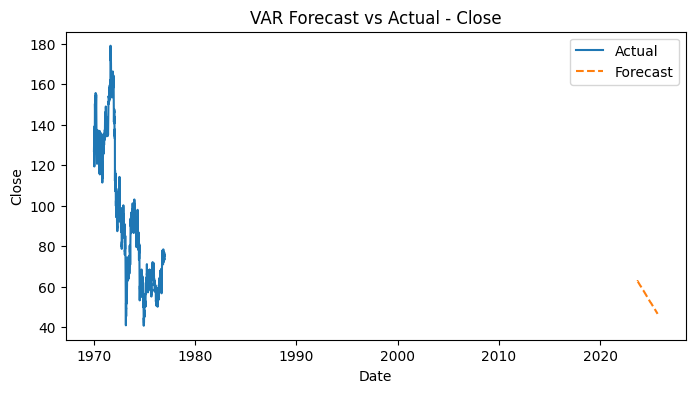

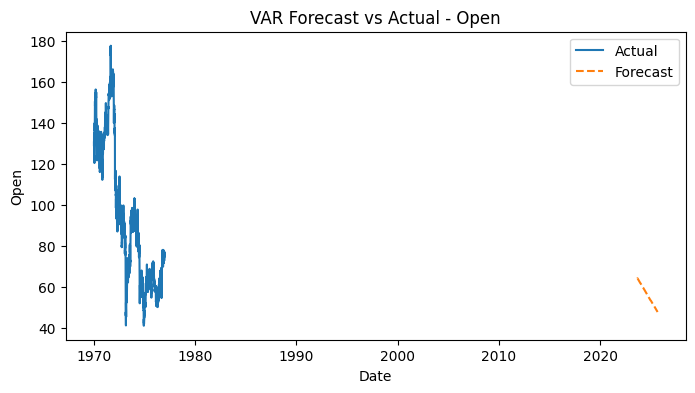

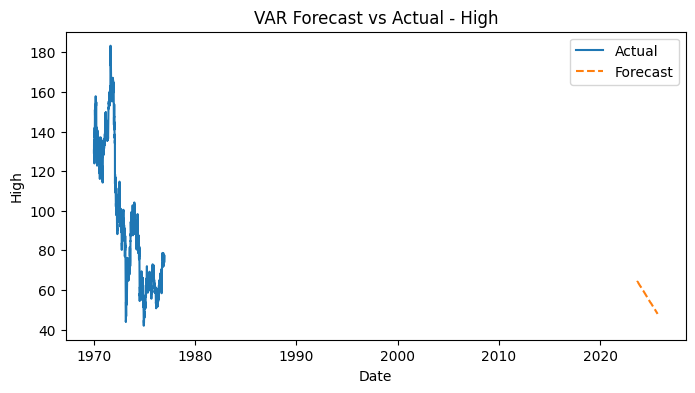

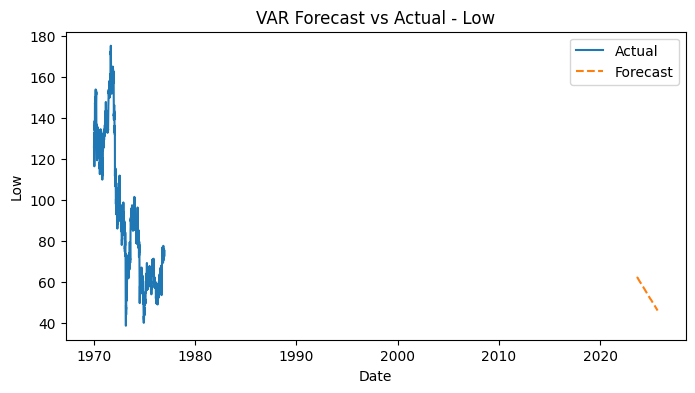

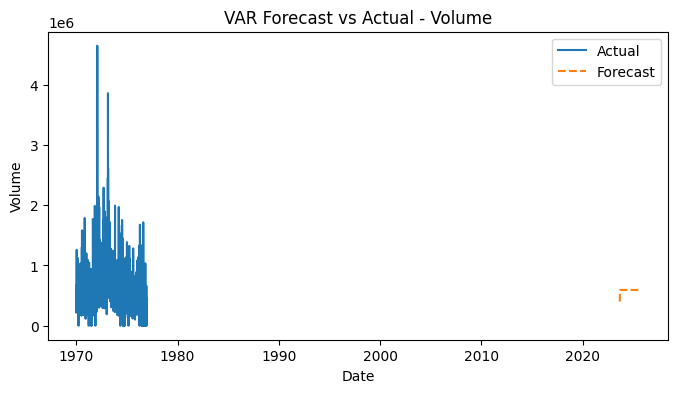

KeyError: 'Date'

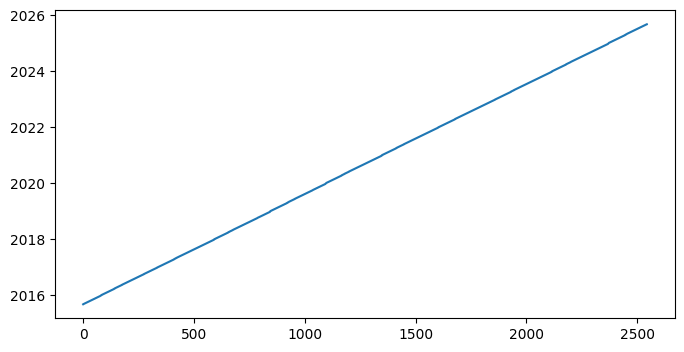

In [16]:
from statsmodels.tsa.api import VAR

# # Set Date as index
# diffed = diffed.set_index("Date")
train_size = int(len(diffed) * 0.8)
train, test = diffed.iloc[:train_size], diffed.iloc[train_size:]

# Ensure numeric and no NaNs
train = train.apply(pd.to_numeric, errors='coerce').dropna()
test = test.apply(pd.to_numeric, errors='coerce').dropna()

model = VAR(train)
model_fit = model.fit()

# Forecast for test length
lag_order = model_fit.k_ar
print(lag_order)
input_data = train.values[-lag_order:]
forecast_diff = model_fit.forecast(y=input_data, steps=len(test))

forecast_diff_df = pd.DataFrame(forecast_diff, index=test.index, columns=["Close", "Open", "High", "Low", "Volume"])

# Revert differencing for A and B using last known values from training set
forecast_df = forecast_diff_df.copy()
forecast_df["Open"] = np.r_[conti_stocks_df_new["Open"].iloc[train_size-1], forecast_diff_df["Open"].cumsum() + conti_stocks_df_new["Open"].iloc[train_size-1]][1:]
forecast_df["Close"] = np.r_[conti_stocks_df_new["Close"].iloc[train_size-1], forecast_diff_df["Close"].cumsum() + conti_stocks_df_new["Close"].iloc[train_size-1]][1:]
forecast_df["High"] = np.r_[conti_stocks_df_new["High"].iloc[train_size-1], forecast_diff_df["High"].cumsum() + conti_stocks_df_new["High"].iloc[train_size-1]][1:]
forecast_df["Low"] = np.r_[conti_stocks_df_new["Low"].iloc[train_size-1], forecast_diff_df["Low"].cumsum() + conti_stocks_df_new["Low"].iloc[train_size-1]][1:]
forecast_df["Volume"] = forecast_diff_df["Volume"]  # already stationary, no need to invert

# print("\nForecast vs Actual (head):")
# print(pd.concat([conti_stocks_df_new.iloc[train_size:], forecast_df], axis=1, keys=["Actual", "Forecast"]).head())

# Plot
for col in conti_stocks_df_new.columns:
    if col == 'Date':
        pass
    plt.figure(figsize=(8, 4))
    plt.plot(conti_stocks_df_new.index, conti_stocks_df_new[col], label="Actual")
    plt.plot(forecast_df.index, forecast_df[col], label="Forecast", linestyle="--")
    plt.title(f"VAR Forecast vs Actual - {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()